# Resolution index analysis by Lindsay

# Defining the dataframe

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib_venn import venn3
from datetime import datetime, timedelta
from scipy import stats
import math
import seaborn as sns
%matplotlib inline
sns.set(style='white', color_codes = True)

In [2]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [3]:
ps = ps[["User","Date","Ephys", "Morph", "Post patch?", "Post patch pipette R", "Nucleus sucked in?", "Notes", "Internal version","patch duration", "PCR cycles", "SM_QC_PF", "Time spent extracting cytosol","Picogreen conc. (pg/uL)", "Resolution index", "Res index pctl.", "Bad dates"]]
#ps.dropna(subset = ["SM_QC_PF", "Post patch?"], inplace = True)
ps.dropna(subset = ["Post patch?"], inplace = True)
ps["User"] = ps["User"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps = ps[ps["Bad dates"] != 'x']
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["PCR cycles"] == 21]
ps = ps.drop('Bad dates', 1)
ps["patch duration"] = pd.to_numeric(ps["patch duration"].str.replace(' ',''), errors ='force')
ps["Time spent extracting cytosol"] = pd.to_numeric(ps["Time spent extracting cytosol"].str.replace(' ',''), errors ='force')
ps["Picogreen conc. (pg/uL)"] = pd.to_numeric(ps["Picogreen conc. (pg/uL)"].str.replace(' ',''), errors ='force')
ps = ps[ps["Picogreen conc. (pg/uL)"] < 5000]
ps.dropna(subset = ["Post patch?", "Picogreen conc. (pg/uL)"], inplace = True)
ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
ps.dropna(subset = ["Resolution index"], inplace=True)
#ps["PCR cycles"].value_counts()
ps

,User,Date,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,patch duration,PCR cycles,SM_QC_PF,Time spent extracting cytosol,Picogreen conc. (pg/uL),Resolution index,Res index pctl.
1635,P2,2017-04-19,x,y,Outside-Out,NaN,NaN,NaN,AiV2,6.566667,21.0,pass,1.666667,608.0000,0.923406,68.0
1637,P2,2017-04-19,x,y,Nucleated,NaN,NaN,NaN,AiV2,7.416667,21.0,pass,2.350000,1536.0000,0.000000,11.0
1638,P2,2017-04-19,x,y,Outside-Out,NaN,NaN,NaN,AiV2,4.166667,21.0,pass,2.216667,582.0000,0.322631,25.0
1639,P2,2017-04-19,x,y,Nucleated,NaN,NaN,NaN,AiV2,9.466667,21.0,pass,2.183333,1154.0000,0.322631,25.0
1640,P2,2017-04-19,x,n,No-Seal,NaN,NaN,NaN,AiV2,6.700000,21.0,pass,1.883333,1504.0000,0.000000,11.0
1645,P6,2017-04-19,x,n,No-Seal,NaN,NaN,NaN,AiV2,9.733333,21.0,pass,2.033333,1292.0000,0.000000,11.0
1654,P1,2017-04-20,x,NaN,Nucleated,NaN,NaN,NaN,AiV2,3.766667,21.0,pass,2.366667,890.0000,0.601033,44.0
1655,P1,2017-04-20,x,NaN,No-Seal,NaN,NaN,NaN,AiV2,6.766667,21.0,pass,2.700000,468.0000,0.000000,11.0
1656,P1,2017-04-20,x,NaN,No-Seal,NaN,NaN,NaN,AiV2,10.250000,21.0,pass,1.983333,426.0000,0.000000,11.0
1657,P1,2017-04-20,x,NaN,No-Seal,NaN,NaN,NaN,AiV2,3.816667,21.0,pass,1.933333,514.0000,0.000000,11.0


# Defining Functions

#### defining counting functions

In [4]:
def get_count(x):    
    count = x["Post patch?"].count()
    return count

def calc_pct(part,total):
    pct = float(get_count(part)) / get_count(total)
    return pct

#### defining filtering functions

In [5]:
#input is a dataframe

def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 501))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 500))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 501))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 500))]
    return no
    
def pass_only(df):
    pas = df[df["SM_QC_PF"] == "pass"]
    return pas

def gen_filter(df, col, cond):
    filtr = df[df[col] == cond]
    return filtr

def hi_res(df):
    hi = df[df["Resolution index"] >= 0.8]
    return hi


# Creating a dataframe by post patch class

In [6]:
nuc = nucleated(ps)
nuc["post patch class"] = "Nucleated"

part_nuc = partial_nucleated(ps)
part_nuc["post patch class"] = "Partial nucleated"

out_out = outside_out(ps)
out_out["post patch class"] = "Outside out"

noSeal = no_seal(ps)
noSeal["post patch class"] = "No seal"

entirecell = ps[ps["Post patch?"] == "Entire-Cell"]
entirecell["post patch class"] = "Entire cell"

frames = [nuc, part_nuc, out_out, noSeal]
ps2 = pd.concat(frames)
ps2

C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,User,Date,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,patch duration,PCR cycles,SM_QC_PF,Time spent extracting cytosol,Picogreen conc. (pg/uL),Resolution index,Res index pctl.,post patch class
1637,P2,2017-04-19,x,y,Nucleated,NaN,NaN,NaN,AiV2,7.416667,21.0,pass,2.350000,1536.0000,0.000000,11.0,Nucleated
1639,P2,2017-04-19,x,y,Nucleated,NaN,NaN,NaN,AiV2,9.466667,21.0,pass,2.183333,1154.0000,0.322631,25.0,Nucleated
1654,P1,2017-04-20,x,NaN,Nucleated,NaN,NaN,NaN,AiV2,3.766667,21.0,pass,2.366667,890.0000,0.601033,44.0,Nucleated
1675,P2,2017-04-20,x,NaN,Nucleated,NaN,NaN,NaN,AiV2,6.550000,21.0,pass,2.083333,1701.0000,0.678447,51.0,Nucleated
1688,P1,2017-04-21,?,n,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,7.266667,21.0,pass,2.233333,1211.0000,0.795757,58.0,Nucleated
1692,P2,2017-04-21,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,9.116667,21.0,pass,1.716667,1272.0000,1.000000,100.0,Nucleated
1693,P2,2017-04-21,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,6.133333,21.0,pass,2.000000,775.0000,0.877682,66.0,Nucleated
1701,P2,2017-04-21,x,n,Nucleated,NaN,NaN,NaN,AiV2,3.266667,21.0,pass,1.983333,1134.0000,0.556320,40.0,Nucleated
1711,P1,2017-04-24,x,NaN,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,3.716667,21.0,pass,2.150000,1419.0000,0.601033,44.0,Nucleated
1717,P1,2017-04-24,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette a few small bubbles,AiV2,3.616667,21.0,pass,2.033333,942.0000,1.000000,100.0,Nucleated


# Resolution Index vs post patch condition for pre and post alexa experiments

#### comparing standard to alexa internal

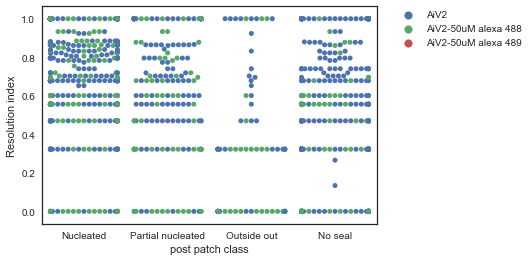

In [7]:
sns.swarmplot(x = "post patch class", y ="Resolution index", hue = "Internal version", data=ps2)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

In [8]:
pre_alexa = gen_filter(ps2, "Internal version", "AiV2")
post_alexa = gen_filter(ps2, "Internal version", "AiV2-50uM alexa 488" )

#### alexa internal only

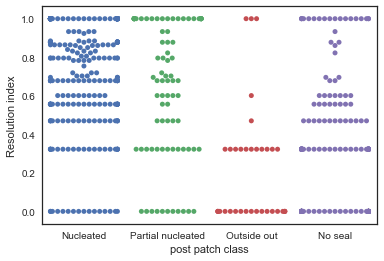

In [9]:
sns.swarmplot(x = "post patch class", y = "Resolution index", data=post_alexa)

#### standard internal only

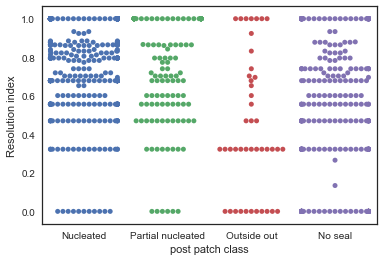

In [10]:
sns.swarmplot(x = "post patch class", y = "Resolution index", data = pre_alexa)

# Calculating occurance of resolution index > 0.8 (high resolution)

### First attempts:

In [11]:
for frame in frames:
    hi_res_occurance = calc_pct(hi_res(frame), frame)
    print "high resolution occurance:" , hi_res_occurance

high resolution occurance: 0.576512455516
high resolution occurance: 0.468181818182
high resolution occurance: 0.153846153846
high resolution occurance: 0.248


In [12]:
def hi_res_occur(frame, postpatch):
    hi_res_occurance = calc_pct(hi_res(frame), frame)
    print postpatch,":", hi_res_occurance
    
hi_res_occur(nuc, "Nucleated")
hi_res_occur(part_nuc, "Partial Nucleated")
hi_res_occur(out_out, "Outside out")
hi_res_occur(noSeal, "No Seal")
hi_res_occur(entirecell, "Entire cell")

Nucleated : 0.576512455516
Partial Nucleated : 0.468181818182
Outside out : 0.153846153846
No Seal : 0.248
Entire cell : 0.5


### Use this one:

In [13]:
# calculates the occurance of high resolution index for each post patch condition

def hi_res_occ(frame, postpatch):
    total = gen_filter(frame, "post patch class", postpatch)
    hi_reso = hi_res(total)
    hi_res_oc = calc_pct(hi_reso, total)
    print postpatch, ":" , hi_res_oc

hi_res_occ(ps2, "Nucleated")
hi_res_occ(ps2, "Partial nucleated")
hi_res_occ(ps2,"Outside out")
hi_res_occ(ps2,"No seal")
#hi_res_occ(ps2,"Entire cell")
    

Nucleated : 0.576512455516
Partial nucleated : 0.468181818182
Outside out : 0.153846153846
No seal : 0.248


# Calculating occurance of resolution index > 0.8 (high resolution) by internal version

#### Occurance of high resolution index in pre alexa expreiments

In [14]:
hi_res_occ(pre_alexa, "Nucleated")
hi_res_occ(pre_alexa, "Partial nucleated")
hi_res_occ(pre_alexa,"Outside out")
hi_res_occ(pre_alexa,"No seal")
#hi_res_occ(pre_alexa,"Entire cell")

Nucleated : 0.59619047619
Partial nucleated : 0.507352941176
Outside out : 0.209302325581
No seal : 0.325806451613


#### Occurance of high resolution index in post alexa expreiments

In [15]:
hi_res_occ(post_alexa, "Nucleated")
hi_res_occ(post_alexa, "Partial nucleated")
hi_res_occ(post_alexa,"Outside out")
hi_res_occ(post_alexa,"No seal")
#hi_res_occ(post_alexa,"Entire cell")

Nucleated : 0.54746835443
Partial nucleated : 0.395061728395
Outside out : 0.0857142857143
No seal : 0.121052631579


# Resolution Index Percentile vs post patch condition for pre and post alexa experiments

#### comparing standard to alexa internal

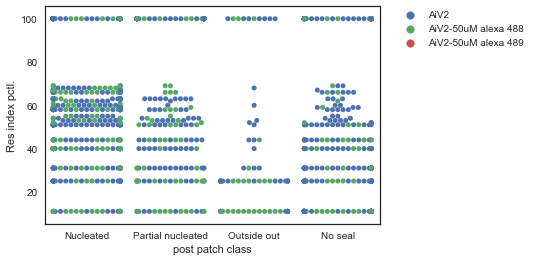

In [16]:
sns.swarmplot(x = "post patch class", y ="Res index pctl.", hue = "Internal version", data=ps2)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

# Calculating occurance of Triple Modality experiments (Ephys pass, Morpho pass, High RI)

In [17]:
Ephys_pass = gen_filter(ps2, "Ephys", "x")
Morpho_pass = gen_filter(ps2, "Morph", "y")
Trans_pass = hi_res(ps2)
#Ephys_pass
Trans_pass

,User,Date,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,patch duration,PCR cycles,SM_QC_PF,Time spent extracting cytosol,Picogreen conc. (pg/uL),Resolution index,Res index pctl.,post patch class
1692,P2,2017-04-21,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,9.116667,21.0,pass,1.716667,1272.0000,1.000000,100.0,Nucleated
1693,P2,2017-04-21,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,6.133333,21.0,pass,2.000000,775.0000,0.877682,66.0,Nucleated
1717,P1,2017-04-24,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette a few small bubbles,AiV2,3.616667,21.0,pass,2.033333,942.0000,1.000000,100.0,Nucleated
1750,P2,2017-04-25,x,n,Nucleated,NaN,NaN,NaN,AiV2,4.516667,21.0,pass,2.366667,840.0000,1.000000,100.0,Nucleated
1751,P2,2017-04-25,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,9.683333,21.0,pass,2.333333,1085.0000,1.000000,100.0,Nucleated
1755,P2,2017-04-25,x,q,Nucleated,NaN,NaN,no bubbles during expulsion.,AiV2,6.133333,21.0,pass,2.150000,641.0000,1.000000,100.0,Nucleated
1830,P2,2017-04-28,x,q,Nucleated,NaN,NaN,one small bubble formed during expulsion.,AiV2,5.416667,21.0,pass,3.550000,1236.0000,1.000000,100.0,Nucleated
1858,P2,2017-05-01,x,q,Nucleated,NaN,NaN,Fluorescence in Pipette one big bubble formed ...,AiV2,4.433333,21.0,pass,2.650000,2152.0000,1.000000,100.0,Nucleated
1865,P6,2017-05-01,x,q,Nucleated,NaN,NaN,NaN,AiV2,3.116667,21.0,pass,2.033333,1885.0000,0.805486,58.0,Nucleated
1891,P2,2017-05-02,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette sucked up nucleus duri...,AiV2,4.500000,21.0,pass,2.616667,1908.0000,1.000000,100.0,Nucleated


In [18]:
Ephys_and_morpho_pass = gen_filter(Ephys_pass, "Morph", "y")
Ephys_and_trans_pass = gen_filter(Trans_pass, "Ephys", "x")
Trans_and_morpho_pass = gen_filter(Trans_pass, "Morph", "y")
#Ephys_and_morpho_pass

In [19]:
Triple_mod = hi_res(Ephys_and_morpho_pass)
Triple_mod

,User,Date,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,patch duration,PCR cycles,SM_QC_PF,Time spent extracting cytosol,Picogreen conc. (pg/uL),Resolution index,Res index pctl.,post patch class
1693,P2,2017-04-21,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,6.133333,21.0,pass,2.000000,775.0000,0.877682,66.0,Nucleated
1717,P1,2017-04-24,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette a few small bubbles,AiV2,3.616667,21.0,pass,2.033333,942.0000,1.000000,100.0,Nucleated
1891,P2,2017-05-02,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette sucked up nucleus duri...,AiV2,4.500000,21.0,pass,2.616667,1908.0000,1.000000,100.0,Nucleated
1892,P2,2017-05-02,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette sucked nucleus up into...,AiV2,5.416667,21.0,pass,3.350000,2079.0000,1.000000,100.0,Nucleated
1916,P1,2017-05-03,x,y,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed lots of ...",AiV2,5.100000,21.0,pass,2.366667,1637.0000,1.000000,100.0,Nucleated
1917,P1,2017-05-03,x,y,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed lots of ...",AiV2,3.783333,21.0,pass,2.316667,1690.0000,1.000000,100.0,Nucleated
1927,P2,2017-05-03,x,y,Nucleated,NaN,NaN,few small bubbles formed during expulsion.,AiV2,4.383333,21.0,pass,2.450000,4743.0000,1.000000,100.0,Nucleated
1928,P2,2017-05-03,x,y,Nucleated,NaN,NaN,lots of little bubbles formed during expulsion...,AiV2,6.600000,21.0,pass,3.650000,2963.0000,1.000000,100.0,Nucleated
1961,P2,2017-05-04,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette no bubbles formed duri...,AiV2,5.566667,21.0,pass,3.266667,2990.0000,1.000000,100.0,Nucleated
1964,P2,2017-05-04,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette No bubbles formed duri...,AiV2,5.250000,21.0,pass,2.416667,1682.0000,1.000000,100.0,Nucleated


In [20]:
calc_pct(Triple_mod, ps2)

0.11882998171846434

In [21]:
lindsay_trip = gen_filter(Triple_mod, "User", "P8")
#lindsay_trip
lindsay = gen_filter(ps2, "User", "P8")
calc_pct(lindsay_trip, lindsay)

0.15098468271334792

# Plots

In [22]:
a = get_count(Ephys_pass)
b = get_count(Morpho_pass)
c = get_count(Ephys_and_morpho_pass)
d = get_count(Trans_pass)
e = get_count(Ephys_and_trans_pass)
f = get_count(Trans_and_morpho_pass)
g = get_count(Triple_mod)

#v=venn3(subsets = (a, b, c, d,e,f,g), set_labels = ('Ephys Pass', 'Morpho Pass', 'RI > 0.8'))
#plt.savefig("Triple mod plot",dpi=200)
#plt.show()

In [23]:
hi_res_data = hi_res(ps2)
hi_res_data

,User,Date,Ephys,Morph,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,patch duration,PCR cycles,SM_QC_PF,Time spent extracting cytosol,Picogreen conc. (pg/uL),Resolution index,Res index pctl.,post patch class
1692,P2,2017-04-21,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,9.116667,21.0,pass,1.716667,1272.0000,1.000000,100.0,Nucleated
1693,P2,2017-04-21,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,6.133333,21.0,pass,2.000000,775.0000,0.877682,66.0,Nucleated
1717,P1,2017-04-24,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette a few small bubbles,AiV2,3.616667,21.0,pass,2.033333,942.0000,1.000000,100.0,Nucleated
1750,P2,2017-04-25,x,n,Nucleated,NaN,NaN,NaN,AiV2,4.516667,21.0,pass,2.366667,840.0000,1.000000,100.0,Nucleated
1751,P2,2017-04-25,x,n,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,9.683333,21.0,pass,2.333333,1085.0000,1.000000,100.0,Nucleated
1755,P2,2017-04-25,x,q,Nucleated,NaN,NaN,no bubbles during expulsion.,AiV2,6.133333,21.0,pass,2.150000,641.0000,1.000000,100.0,Nucleated
1830,P2,2017-04-28,x,q,Nucleated,NaN,NaN,one small bubble formed during expulsion.,AiV2,5.416667,21.0,pass,3.550000,1236.0000,1.000000,100.0,Nucleated
1858,P2,2017-05-01,x,q,Nucleated,NaN,NaN,Fluorescence in Pipette one big bubble formed ...,AiV2,4.433333,21.0,pass,2.650000,2152.0000,1.000000,100.0,Nucleated
1865,P6,2017-05-01,x,q,Nucleated,NaN,NaN,NaN,AiV2,3.116667,21.0,pass,2.033333,1885.0000,0.805486,58.0,Nucleated
1891,P2,2017-05-02,x,y,Nucleated,NaN,NaN,Fluorescence in Pipette sucked up nucleus duri...,AiV2,4.500000,21.0,pass,2.616667,1908.0000,1.000000,100.0,Nucleated


#### Resolution index vs post patch outcome

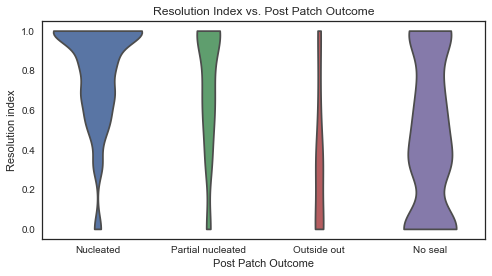

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
sns.violinplot(x="post patch class", y="Resolution index", data=ps2, inner=None, cut =0, scale='count',ax=ax)
#sns.swarmplot(x="post patch class", y="Resolution index", data=ps2, color="w", alpha=.5);
#sns.swarmplot(x="post patch class", y="Resolution index", data=hi_res_data, color="w", alpha=.5);
#sns.set_context("poster")
plt.title("Resolution Index vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot",dpi=200)


#### Resolution index vs post patch outcome: scale = area

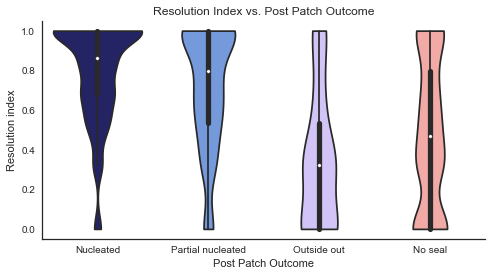

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
sns.violinplot(x="post patch class", y="Resolution index", data=ps2, inner='box', cut =0, scale='area', palette=['midnightblue', 'cornflowerblue', '#D0BBFF', "#FF9F9A"],ax=ax)
sns.despine()
plt.title("Resolution Index vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot-area",dpi=300)


In [26]:
ps["Date"].head()

1635   2017-04-19
1637   2017-04-19
1638   2017-04-19
1639   2017-04-19
1640   2017-04-19
Name: Date, dtype: datetime64[ns]

In [27]:
ps["Date"].tail()

4428   2017-10-31
4429   2017-10-31
4430   2017-10-31
4431   2017-10-31
4432   2017-10-31
Name: Date, dtype: datetime64[ns]

#### Plot for Brian - Nucleated patch Reolution Index only

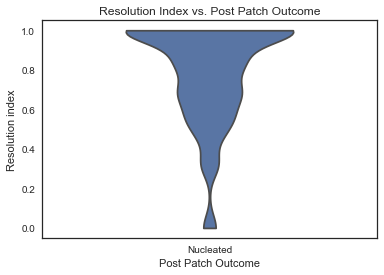

In [28]:
ps3= gen_filter(ps2, "post patch class", "Nucleated")
sns.violinplot(x="post patch class", y="Resolution index", data=ps3, inner=None, cut =0, scale='area', width=0.5)
plt.title("Resolution Index vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
#plt.tight_layout()
plt.savefig("RI plot-nucleated",dpi=200)


#### Resolution index percentile vs post patch outcome

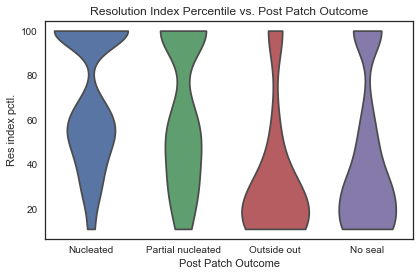

In [29]:
sns.violinplot(x="post patch class", y="Res index pctl.", data=ps2, inner=None, cut =0, scale='area')
plt.title("Resolution Index Percentile vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI percentile plot-area",dpi=200)


#### Resolution index vs post patch outcome: scale = area PRE ALEXA

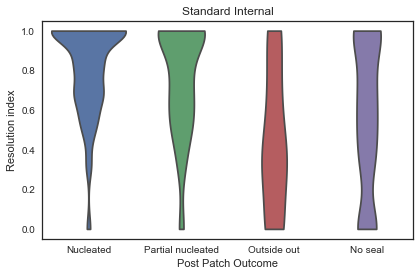

In [30]:
sns.violinplot(x="post patch class", y="Resolution index", data=pre_alexa, inner=None, cut =0, scale='area')
plt.title("Standard Internal")
plt.xlabel("Post Patch Outcome")
#plt.figure(figsize=(8, 6))
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot-pre_alexa",dpi=200)

#### Resolution index vs post patch outcome: scale = area POST ALEXA

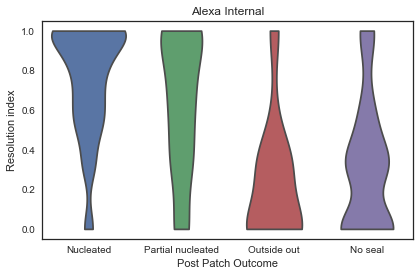

In [31]:
sns.violinplot(x="post patch class", y="Resolution index", data=post_alexa, inner=None, cut =0, scale='area')
plt.title("Alexa Internal")
plt.xlabel("Post Patch Outcome")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("RI plot-post_alexa",dpi=200)

#### Comparing RI standard internal vs alexa

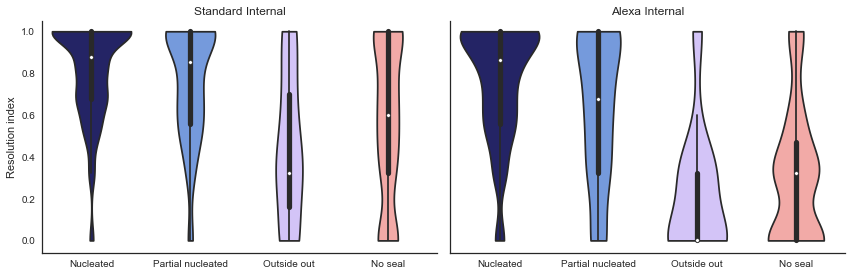

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey= True)
#f, (ax1, ax2) = plt.subplots(2, figsize=(7,7))
sns.violinplot(x="post patch class", y="Resolution index", data=pre_alexa, inner="box", cut =0, scale='area', ax=ax1, palette=['midnightblue', 'cornflowerblue', '#D0BBFF', "#FF9F9A"])
ax1.set_title("Standard Internal")
ax1.set_xlabel('')
sns.violinplot(x="post patch class", y="Resolution index", data=post_alexa, inner="box", cut =0, scale='area', ax=ax2, palette=['midnightblue', 'cornflowerblue', '#D0BBFF', "#FF9F9A"])
ax2.set_title("Alexa Internal")
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.tight_layout()
sns.despine()
plt.savefig("RI plot-alexa vs standard", dpi=100)

In [33]:
#fig, ax = plt.subplots()
#fig.set_size_inches(7, 4)
#sns.violinplot(x="post patch class", y="Resolution index", data=ps2, hue ="Internal version" ,inner="box", split= True, cut =0, scale='area')
#plt.tight_layout()
#sns.despine()
#plt.savefig("RI plot-alexa vs standard split", dpi=100)

In [34]:
ps["Resolution index"].mean()

0.661104155265469

In [35]:
get_count(post_alexa)

622

In [36]:
get_count(pre_alexa)

1014

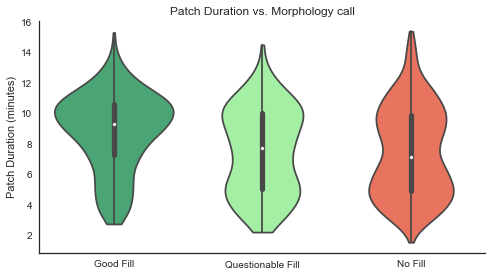

In [37]:
psm = ps2[(ps2["Morph"] == 'y') | (ps2['Morph'] == 'q') | (ps2['Morph'] == 'n')]
psm = psm[psm["patch duration"] < 15.5]
fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
sns.violinplot(x="Morph", y="patch duration", data=psm, inner='box', cut =0, scale='area', palette =["mediumseagreen","palegreen", "tomato"], order = ["y", "q", "n"],ax=ax)
sns.despine()
plt.title("Patch Duration vs. Morphology call")
plt.xlabel(" ")
plt.ylabel("Patch Duration (minutes)")
ax.set_xticklabels(["Good Fill", "Questionable Fill", "No Fill"])
plt.tight_layout()
plt.savefig("morph",dpi=300)

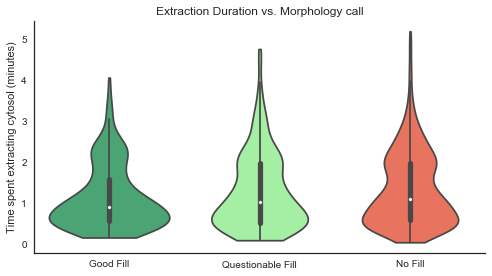

In [38]:
psm = ps2[(ps2["Morph"] == 'y') | (ps2['Morph'] == 'q') | (ps2['Morph'] == 'n')]
#psm = psm[psm["patch duration"] < 15.5]
fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
sns.violinplot(x="Morph", y="Time spent extracting cytosol", data=psm, inner='box', cut =0, scale='area', palette =["mediumseagreen","palegreen", "tomato"], order = ["y", "q", "n"],ax=ax)
sns.despine()
plt.title("Extraction Duration vs. Morphology call")
plt.xlabel(" ")
plt.ylabel("Time spent extracting cytosol (minutes)")
ax.set_xticklabels(["Good Fill", "Questionable Fill", "No Fill"])
plt.tight_layout()
plt.savefig("morph2",dpi=300)

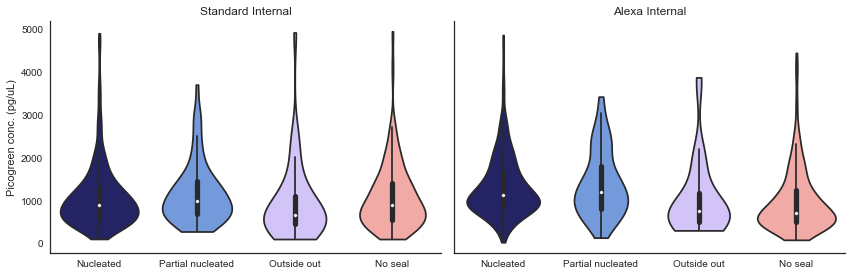

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey= True)
#f, (ax1, ax2) = plt.subplots(2, figsize=(7,7))
sns.violinplot(x="post patch class", y="Picogreen conc. (pg/uL)", data=pre_alexa, inner="box", cut =0, scale='area',palette=['midnightblue', 'cornflowerblue', '#D0BBFF', "#FF9F9A"], ax=ax1)
ax1.set_title("Standard Internal")
ax1.set_xlabel('')
sns.violinplot(x="post patch class", y="Picogreen conc. (pg/uL)", data=post_alexa, inner="box", cut =0, scale='area',palette=['midnightblue', 'cornflowerblue', '#D0BBFF', "#FF9F9A"], ax=ax2)
ax2.set_title("Alexa Internal")
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.tight_layout()
sns.despine()
plt.savefig("picogreen-alexa vs standard", dpi=100)

# Creating a monthly report

In [40]:
#this_month = ps2[(ps2['Date'] > '2017-10-01')]
#this_month

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey= True)
#f, (ax1, ax2) = plt.subplots(2, figsize=(7,7))
sns.violinplot(x="post patch class", y="Resolution index", data=post_alexa, inner="box", cut =0, scale='area', ax=ax1, palette=['midnightblue', 'cornflowerblue', '#D0BBFF', "#FF9F9A"])
ax1.set_title("All Production Data")
ax1.set_xlabel('')
sns.violinplot(x="post patch class", y="Resolution index", data=this_month, inner="box", cut =0, scale='area', ax=ax2, palette=['midnightblue', 'cornflowerblue', '#D0BBFF', "#FF9F9A"])
ax2.set_title("This Month")
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.tight_layout()
sns.despine()
plt.savefig("RI plot-monthly", dpi=100)

C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


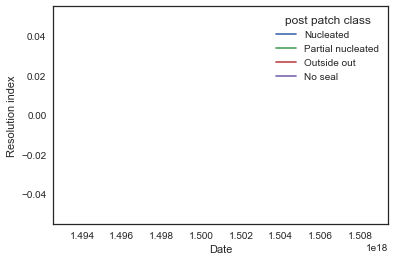

In [41]:
sns.tsplot(data=ps2, time = "Date", condition="post patch class", value="Resolution index")

In [42]:
ps2.dtypes

User                                   category
Date                             datetime64[ns]
Ephys                                    object
Morph                                    object
Post patch?                            category
Post patch pipette R                    float64
Nucleus sucked in?                       object
Notes                                    object
Internal version                         object
patch duration                          float64
PCR cycles                              float64
SM_QC_PF                               category
Time spent extracting cytosol           float64
Picogreen conc. (pg/uL)                 float64
Resolution index                        float64
Res index pctl.                         float64
post patch class                         object
dtype: object

In [43]:
ps2.Date.head()

1637   2017-04-19
1639   2017-04-19
1654   2017-04-20
1675   2017-04-20
1688   2017-04-21
Name: Date, dtype: datetime64[ns]

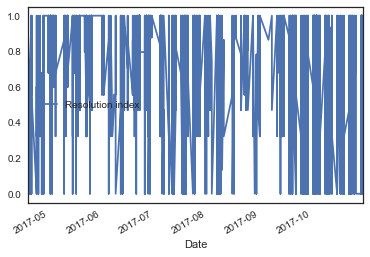

In [44]:
ps2[['Date','Resolution index']].set_index('Date').plot()

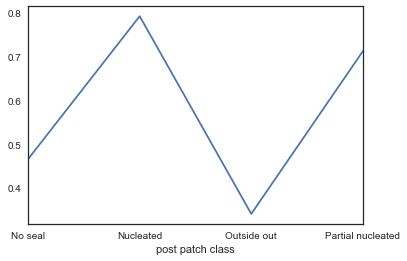

In [45]:
ps2.groupby("post patch class")["Resolution index"].mean().plot()

In [46]:
ps2.set_index("Date",inplace=True)


In [47]:
ps2.index.week

Int64Index([16, 16, 16, 16, 16, 16, 16, 16, 17, 17,
            ...
            44, 44, 44, 44, 44, 44, 44, 44, 44, 44],
           dtype='int64', name=u'Date', length=1641)

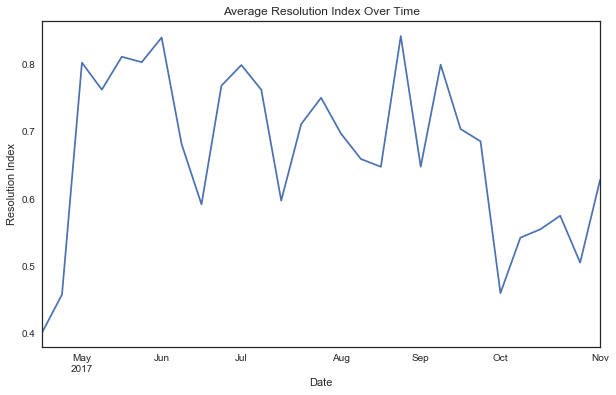

In [48]:
ps2.groupby(pd.TimeGrouper(freq="W")).mean()["Resolution index"].plot(figsize= (10,6))
plt.title("Average Resolution Index Over Time")
plt.ylabel("Resolution Index")
plt.savefig("Resolution_Index_Over_Time")

In [49]:
ps2.groupby(pd.TimeGrouper(freq="W"))

In [50]:
ps3 = ps2.groupby("post patch class")["Resolution index"].mean()
ps3

post patch class
No seal              0.465829
Nucleated            0.791614
Outside out          0.341102
Partial nucleated    0.711889
Name: Resolution index, dtype: float64